In [91]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [92]:
# This creates a computational graph 
sess = tf.Session()

- Declare our Tensors and placeholders
- We create numpy array to feed in the data 

In [93]:
x_vals = np.array([1,3,4,5,7,9]) # Declaring the np array data 
x_data = tf.placeholder(tf.float32) # Creating a placeholder for data
m_const = tf.constant(3.) # Declaring a constant
my_product = tf.multiply(x_data, m_const) # Operation multiplication
for x_val in x_vals:
    print(sess.run(my_product,feed_dict={x_data:x_val})) # Running the operation with data values 

3.0
9.0
12.0
15.0
21.0
27.0


### Chaining operations together 

- Example multiply a placeholder with two matrices and then perform addition
- For Placeholders for matrix we have to declare the shape and know the outcome shape 
- Sometimes we may not know the shape of the outcome for that we write dimesion value as **None**
- For Example we don't know certain number of cols 
    * x_data = tf.placeholder(tf.float32, shape=(3,None))

In [94]:
# First we create data to feed in and corresponding placeholder

my_array = np.array([[1,3,5,7,9],
                    [-2,0,2,4,6],
                    [-6,-3,0,3,6]])
x_vals = np.array([my_array, my_array + 1]) # Two 3X5 numpy array matrix 
x_data = tf.placeholder(tf.float32, shape=(3, 5)) # Created a placeholder with 3X5 data receiver 

In [95]:
# Next we create constants that we will use for Matrix multiplication and addition

m1 = tf.constant([[1.],[0.],[-1.],[2.],[4.]])
m2 = tf.constant([[2.]])
a1 = tf.constant([[10.]])

In [96]:
# Next we declare the operations 

prod1 = tf.matmul(x_data,m1)  # Multiplying 3X5 with 5X1 result it 3X1
prod2 = tf.matmul(prod1, m2)  # Multiplying 3X1 with 1X1 result is 3X1
add1 = tf.add(prod2,a1)

In [97]:
# Finally we feed the data through the coputational graph 

for x_val in x_vals:
    print(sess.run(add1,feed_dict={x_data: x_val}))

[[ 102.]
 [  66.]
 [  58.]]
[[ 114.]
 [  78.]
 [  70.]]


### Working with Multiple Layers
- In this section we will see that computational graph can get large and complex 
- We will introduce name operations and scopes for layers 

In [98]:
# Creating a sample 2D image of 4X4 pixel image 
# Creating it in 4 dimensions , 1st and last dimension has size of one 
# Note some TF image func operate on 4D images (img #, Height, Width, Channel)

x_shape = [1,4,4,1]
x_val = np.random.uniform(size=x_shape)

In [99]:
# Create Placeholder 
x_data = tf.placeholder(tf.float32, shape=x_shape)

- To create a moving window average across 4X4 image
- we use built in function that will convolute a constant across a window of shape 2X2
- This function is quite common among image processing *conv2d()*
- This function takes in peicewise product of the window and a filter that we specify
- we must also specify stride 

In [100]:
my_filter = tf.constant(0.25, shape=[2,2,1,1])
my_stride = [1,2,2,1]
mov_avg_layer = tf.nn.conv2d(x_data,my_filter,my_stride, padding='SAME''', name='Moving_Avg_Window')

In [101]:
# Now we define custom layer that will operate on 2x2 output of the moving window average 
# First we multiply 2X2 matrix with another 2X2 matrix and then add one to each entry (Ax + b)
# Since the matrix multiplication only operate on the 2 dimensional matrix we need to drop few extra dimensions 
# We can do this by using built in function squeeze()

def custom_layer(input_matrix):
    input_matrix_squeezed = tf.squeeze(input_matrix)
    A = tf.constant([[1.,2.],[-1.,3.]])
    b = tf.constant(1., shape=[2,2])
    temp1 = tf.matmul(A,input_matrix_squeezed)
    temp = tf.add(temp1, b) # Ax + b
    return(tf.sigmoid(temp))

In [102]:
# Now we place the new layer on the graph 
# We do this with a named scope so that is identifiable and collapsible/expandable on computational graph

with tf.name_scope('Custom_Layer') as scope:
    custom_layer1 = custom_layer(mov_avg_layer)

In [103]:

# Finally we just feed in the 4X4 matrix

print(sess.run(custom_layer1, feed_dict={x_data:x_val}))

[[ 0.9568184   0.84790617]
 [ 0.92529565  0.77374595]]


## Implementing the Loss Function 

- Loss function is very important to machine learning algorithms
- Measure the distance between the model output and target(truth) values 
- In order to optimize our machine learning algorithm we will need to evaluate the outcome that's where the loss function comes into play 
- Loss function tells TensorFlow how good or bad our prediction is compared to desired result 
- Loss function compares the **Target** with **Prediction** and gives a numerical distance between the two 

- First we'll talk about the loss function in Regression ie. predicting continous dependent variable 
- For start we'll create a sequence of predictions and target as a Tensor
- Will output the result across 500 x-values between -1 and 1

In [104]:
x_vals = tf.linspace(-1.,1.,500)
target = tf.constant(0.)
x_array = sess.run(x_vals)

- The L2 norm loss is also known as **Euclidean** loss function
- It is the sqaure of the distance to the target
- Here we'll compute the loss function as if the target is zero 

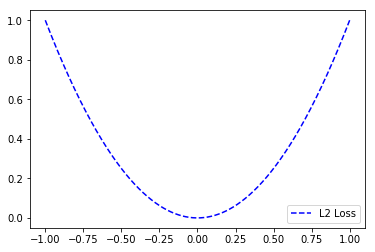

In [105]:
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)
plt.plot(x_array, l2_y_out, 'b--', label='L2 Loss')
plt.legend(loc='lower right')

- L1 loss function is also know as absolute loss function 
- Instead of sqauring the differences we take the absolute value 
- L1 is better for outlier than L2 norm since it's not steep for larger values 
- L1 is not smooth though

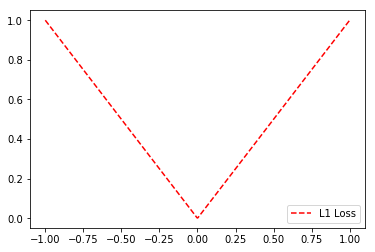

In [106]:
l1_y_vals = tf.abs(target - x_vals)
l1_y_out = sess.run(l1_y_vals)
plt.plot(x_array, l1_y_out, 'r--', label='L1 Loss')
plt.legend(loc='lower right')

- **Pseudo huber loss** is continous and smooth approximation to Huber Loss function 
- This loss function attempts to take the best from L1 and L2 by being convex near the Target and less steep for extreme values 
- Depends on extra parameter delta indicating how steep it will be 

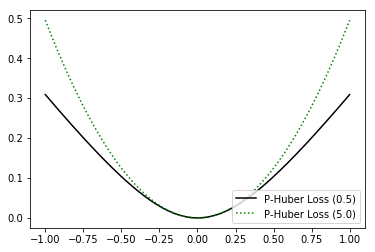

In [107]:
hub_delta_1 = tf.constant(0.5)
hub_delta_2 = tf.constant(5.)

phuber1_y_vals = tf.multiply(tf.square(hub_delta_1), tf.sqrt(1. + tf.square((target - x_vals)/ hub_delta_1)) - 1.)
phuber1_y_out = sess.run(phuber1_y_vals)

phuber2_y_vals = tf.multiply(tf.square(hub_delta_2), tf.sqrt(1. + tf.square((target - x_vals)/ hub_delta_2)) - 1.)
phuber2_y_out = sess.run(phuber2_y_vals)

plt.plot(x_array, phuber1_y_out, 'k-', label='P-Huber Loss (0.5)')
plt.plot(x_array, phuber2_y_out, 'g:', label='P-Huber Loss (5.0)')
plt.legend(loc='lower right')

In [121]:
# Redefining our predictions (x_vals) and target

x_vals = tf.linspace(-1., 5., 500)
target = tf.constant(1.)
targets = tf.fill([500,], 1.)

- **Hinge Loss** is mostly used for support vector machines but can also be used in Neural Network as well
- It's meant to compute the loss between two target classes 1 and -1 


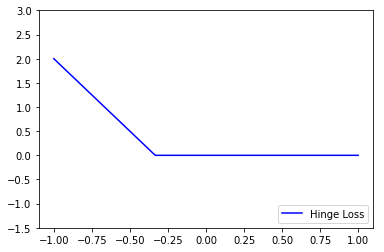

In [110]:
hinge_y_vals = tf.maximum(0., 1. - tf.multiply(target, x_vals))
hinge_y_out = sess.run(hinge_y_vals)
plt.plot(x_array, hinge_y_out, 'b-', label='Hinge Loss')
plt.ylim(-1.5, 3)
plt.legend(loc='lower right')

- ** Cross Entropy Loss** for binary case is also refered to as the logistic loss func
- It comes about when we are predicting the two classes 0 and 1 
- We wish to measure the distance from actual class to the predicted value
- Given by the cross entropy formula

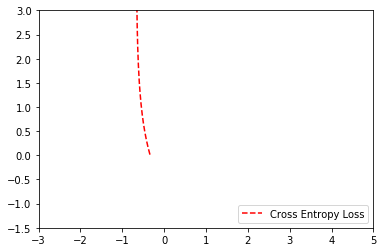

In [112]:
xentropy_y_vals = - tf.multiply(target, tf.log(x_vals)) - tf.multiply((1. - target), tf.log(1. - x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)
plt.plot(x_array, xentropy_y_out, 'r--', label='Cross Entropy Loss')
plt.ylim(-1.5, 3)
plt.xlim(-3,5)
plt.legend(loc='lower right')

- ** Sigmoid cross entropy loss ** is very similar to the previous loss function 
- Except we transform the x _values by the sigmoid function before we put them to cross entropy loss 

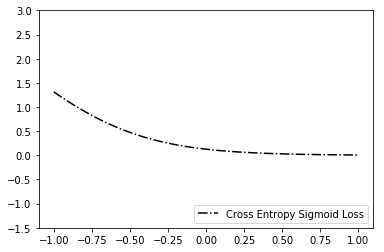

In [118]:
xentropy_sigmoid_y_vals = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_vals, labels=targets)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)
plt.plot(x_array, xentropy_sigmoid_y_out, 'k-.', label='Cross Entropy Sigmoid Loss')
plt.ylim(-1.5, 3)
plt.legend(loc='lower right')

- ** Weighted cross entropy loss ** is weighted version of the *sigmoid cross entropy loss* 
- we provide weight on the positive target
- eg. we will weight the positive target by 0.5


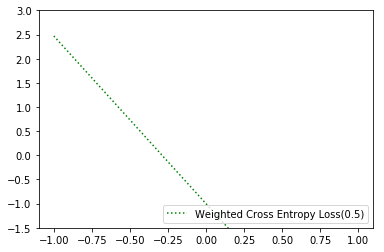

In [122]:
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(x_vals, targets, weight)
xentropy_weighted_y_out = sess.run(xentropy_weighted_y_vals)
plt.plot(x_array, xentropy_weighted_y_out, 'g:', label='Weighted Cross Entropy Loss(0.5)')
plt.ylim(-1.5, 3)
plt.legend(loc='lower right')

- **Softmax Cross Entropy loss** operates on non-normalized outputs 
- This is used to measure loss when there is only one target category instead of multiple 
- Function transforms the output into a probability distribution via the softmax function 

In [81]:
unscaled_logits = tf.constant([[1., -3., 10.]])
target_dist = tf.constant([[0.1, 0.02, 0.88]])
softmax_xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=target_dist)
print(sess.run(softmax_xentropy))

[ 1.16012561]


- ** Sparse Softmax cross-entropy loss** is the same as previous one
- Except the target being a probability distibution it is index of which category is true
- Instead of a sparse all-zero vector with one value of one we pass in index of which category is true


In [83]:
unscaled_logits = tf.constant([[1., -3., 10.]])
sparse_target_dist = tf.constant([2])
sparse_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=sparse_target_dist)
print(sess.run(sparse_xentropy))

[ 0.00012564]
